## Using Random Survival Forests

As it’s popular counterparts for classification and regression, a Random Survival Forest is an ensemble of tree-based learners. A Random Survival Forest ensures that individual trees are de-correlated by 

1) building each tree on a different bootstrap sample of the original training data, and 

2) at each node, only evaluate the split criterion for a randomly selected subset of features and thresholds. 

Predictions are formed by aggregating predictions of individual trees in the ensemble.

Reference: https://scikit-survival.readthedocs.io/en/stable/user_guide/random-survival-forest.html


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

To demonstrate Random Survival Forest, we are going to use data from the German Breast Cancer Study Group (GBSG-2) on the treatment of node-positive breast cancer patients. 

It contains data on 686 women and 8 prognostic factors: 
1. age
2. estrogen receptor (estrec)
3. whether or not a hormonal therapy was administered (horTh)
4. menopausal status (menostat)
5. number of positive lymph nodes (pnodes)
6. progesterone receptor (progrec)
7. tumor size (tsize)
8. tumor grade (tgrade).

The dataset is one of the sksurv.datasets 

Goal: The goal is to predict recurrence-free survival time.


In [4]:
#First, we need to load the data and transform it into numeric values.

X, y = load_gbsg2()

grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

X_no_grade = X.drop("tgrade", axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade)
Xt.loc[:, "tgrade"] = grade_num

In [5]:
# Next, the data is split into 75% for training and 25% for testing, so we can determine how well our model generalizes.


random_state = 20

X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.25, random_state=random_state)

## training random survival forest

we fit a Random Survival Forest comprising 1000 trees.

In [6]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)
rsf.fit(X_train, y_train)

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_estimators=1000, n_jobs=-1,
                     random_state=20)

### Evaluate model with concordance score

This gives a concordance index of 0.68, which is a good a value 

In [8]:
rsf.score(X_test, y_test)


0.6759696016771488

## Predicting

For prediction, a sample is dropped down each tree in the forest until it reaches a terminal node. Data in each terminal is used to non-parametrically estimate the survival and cumulative hazard function using the Kaplan-Meier and Nelson-Aalen estimator, respectively. In addition, a risk score can be computed that represents the expected number of events for one particular terminal node. The ensemble prediction is simply the average across all trees in the forest.

Try prediction with 6 samples


In [10]:
X_test_sorted = X_test.sort_values(by=["pnodes", "age"])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

X_test_sel

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tsize,tgrade
119,33.0,0.0,0.0,0.0,1.0,26.0,35.0,2.0
574,34.0,37.0,0.0,0.0,1.0,0.0,40.0,2.0
421,36.0,14.0,0.0,0.0,1.0,76.0,36.0,1.0
24,65.0,64.0,0.0,1.0,26.0,2.0,70.0,2.0
8,80.0,59.0,0.0,1.0,30.0,0.0,39.0,1.0
226,72.0,1091.0,1.0,1.0,36.0,2.0,34.0,2.0


The predicted risk scores indicate that risk for the last three patients is quite a bit higher than that of the first three patients.

In [11]:
# predict risk score
pd.Series(rsf.predict(X_test_sel))


0     91.477609
1    102.897552
2     75.883786
3    170.502092
4    171.210066
5    148.691835
dtype: float64

The predicted risk scores indicate that risk for the last three patients is quite a bit higher than that of the first three patients.

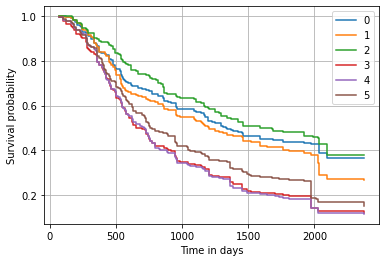

In [12]:
# Predict survival function

surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)


Alternatively, we can also plot the predicted cumulative hazard function.



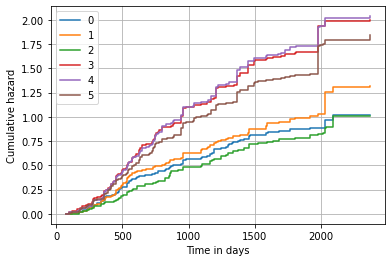

In [13]:
surv = rsf.predict_cumulative_hazard_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

## Permutation-based feature importance

In [14]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rsf, n_iter=15, random_state=random_state)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=Xt.columns.tolist())

Using TensorFlow backend.


Weight,Feature
0.0676 ± 0.0229,pnodes
0.0206 ± 0.0139,age
0.0177 ± 0.0468,progrec
0.0086 ± 0.0098,horTh=yes
0.0032 ± 0.0198,tsize
0.0032 ± 0.0060,tgrade
-0.0007 ± 0.0018,menostat=Post
-0.0063 ± 0.0207,estrec
